In [1]:
import nltk   
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from wordcloud import WordCloud

import re
from itertools import chain
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')  
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
stopword = set(stopwords.words('english'))  

In [4]:
df=pd.read_csv('/content/data_set.csv')
df

,Unnamed: 0,comments
0,0,The following is a copy of the original post t...
1,1,>Do you think Black politics are treated as ra...
2,2,"Yes. We treat white, male, CIS, heterosexual, ..."
3,3,Any politics that acknowledges America's histo...
4,4,Gonna throw this out there: \n\n1) White natio...
...,...,...
106,106,You’ll note this thread started cause someone ...
107,107,Liberals love to tell oppressed people to ask ...
108,108,That’s not enough. We will continue to press f...
109,109,Institutions which you support. You already ma...


In [5]:
# sentiment analysis
sentiment =  SentimentIntensityAnalyzer()
sentiment_data = [*df['comments'].apply(sentiment.polarity_scores)]
sentiment_data

[{'compound': 0.5574, 'neg': 0.0, 'neu': 0.932, 'pos': 0.068},
 {'compound': -0.0772, 'neg': 0.094, 'neu': 0.815, 'pos': 0.091},
 {'compound': 0.6597, 'neg': 0.0, 'neu': 0.735, 'pos': 0.265},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0772, 'neg': 0.045, 'neu': 0.904, 'pos': 0.051},
 {'compound': -0.802, 'neg': 0.163, 'neu': 0.837, 'pos': 0.0},
 {'compound': 0.1593, 'neg': 0.044, 'neu': 0.887, 'pos': 0.069},
 {'compound': 0.2023, 'neg': 0.091, 'neu': 0.799, 'pos': 0.11},
 {'compound': 0.0258, 'neg': 0.089, 'neu': 0.818, 'pos': 0.093},
 {'compound': 0.6582, 'neg': 0.037, 'neu': 0.908, 'pos': 0.055},
 {'compound': 0.4019, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'compound': -0.9661, 'neg': 0.151, 'neu': 0.805, 'pos': 0.045},
 {'compound': -0.4391, 'neg': 0.126, 'neu': 0.782, 'pos': 0.092},
 {'compound': 0.7343, 'neg': 0.0, 'neu': 0.857, 'pos': 0.143},
 {'compound': 0.9633, 'neg': 0.032, 'neu': 0.662, 'pos': 0.306},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'po

In [6]:
# convert it into dataframe
sentiment_df = pd.DataFrame.from_records(sentiment_data)
sentiment_df = pd.concat([df, sentiment_df], axis=1, join='inner')
sentiment_df.describe()

,Unnamed: 0,neg,neu,pos,compound
count,111.000000,111.000000,111.000000,111.000000,111.000000
mean,55.000000,0.110766,0.781820,0.107477,-0.116806
std,32.186954,0.113834,0.153023,0.129748,0.628635
min,0.000000,0.000000,0.000000,0.000000,-0.996800
25%,27.500000,0.000000,0.705000,0.000000,-0.746550
50%,55.000000,0.089000,0.785000,0.089000,0.000000
75%,82.500000,0.176500,0.877000,0.151500,0.401900
max,110.000000,0.545000,1.000000,1.000000,0.990000


(-2.0, 2.0)

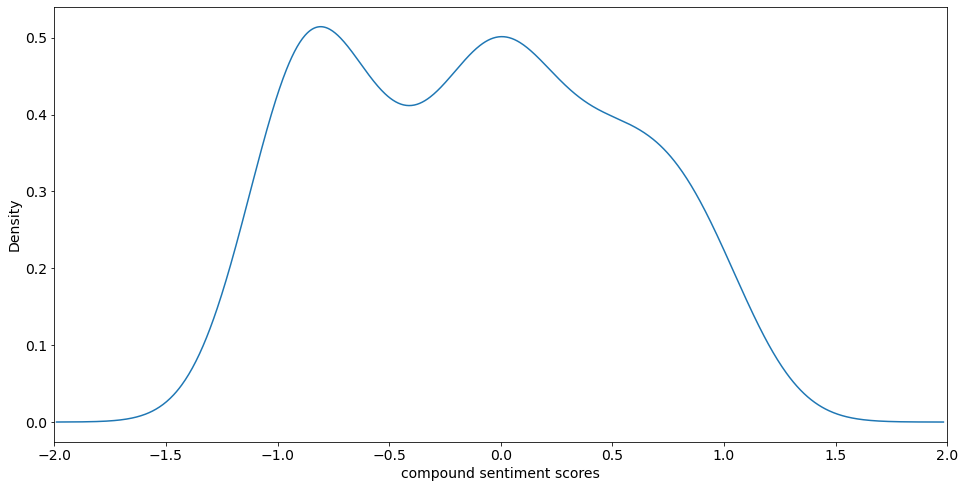

In [7]:
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 14})
sentiment_df['compound'].plot.density(label='Sentiment density')
plt.xlabel('compound sentiment scores')
plt.xlim(-2,2)

As we can see, the sentiment density plot has 2 peaks at -1.0 and 0.0. This plot shows that most of the comments on the post has negative or neutral sentiments  

In [8]:
# We labelled the comments on the  basis of sentiments they express for further clarification  
sentiment_df['label'] = 0   # Neutral
sentiment_df.loc[sentiment_df['compound'] >= 0.05, 'label'] = 1 # Positive
sentiment_df.loc[sentiment_df['compound'] <= -0.05, 'label'] = -1   # Negative

In [9]:
sentiment_df.label.value_counts()

-1    53
 1    40
 0    18
Name: label, dtype: int64

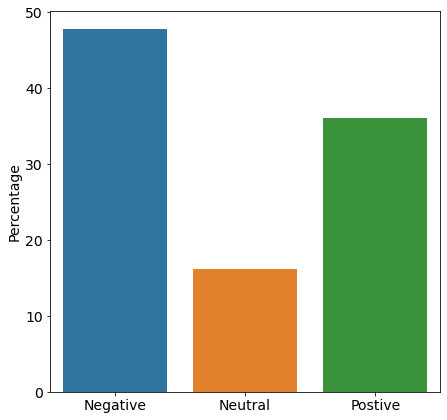

In [10]:
figure, axis = plt.subplots(figsize=(7, 7))
counts = sentiment_df.label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=axis)
axis.set_xticklabels(['Negative', 'Neutral', 'Postive'])
axis.set_ylabel("Percentage")
plt.show()

From above graph, we can see that the percentage of comments with negative sentiment on post is more than the positive and the neutral comments are least. We conclude that the  peak at 0.0 in sentiment density plot is not perfect at 0.

In [11]:
def preprocess(comment):
    preprocess_comment = comment
    preprocess_comment = preprocess_comment.lower()
    preprocess_comment = re.sub(r'\n|[^a-zA-Z]', ' ', preprocess_comment)
    preprocess_comment = ' '.join(word for word in preprocess_comment.split() if word not in stopword)
    return preprocess_comment

sentiment_df['Processed_Comment'] = sentiment_df['comments'].apply(lambda x: preprocess(x)) 

In [12]:
sentiment_df['Processed_Comment'] = sentiment_df['Processed_Comment'].apply(word_tokenize) #tokenization
# lemmetization
lemmatizer = WordNetLemmatizer()
sentiment_df['Processed_Comment'] = sentiment_df['Processed_Comment'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
sentiment_df.head(5)

,Unnamed: 0,comments,neg,neu,pos,compound,label,Processed_Comment
0,0,The following is a copy of the original post t...,0.000,0.932,0.068,0.5574,1,"[following, copy, original, post, record, post..."
1,1,>Do you think Black politics are treated as ra...,0.094,0.815,0.091,-0.0772,-1,"[think, black, politics, treated, radical, pol..."
2,2,"Yes. We treat white, male, CIS, heterosexual, ...",0.000,0.735,0.265,0.6597,1,"[yes, treat, white, male, ci, heterosexual, no..."
3,3,Any politics that acknowledges America's histo...,0.000,1.000,0.000,0.0000,0,"[politics, acknowledges, america, historic, on..."
4,4,Gonna throw this out there: \n\n1) White natio...,0.045,0.904,0.051,0.0772,1,"[gon, na, throw, white, nationalist, group, ab..."


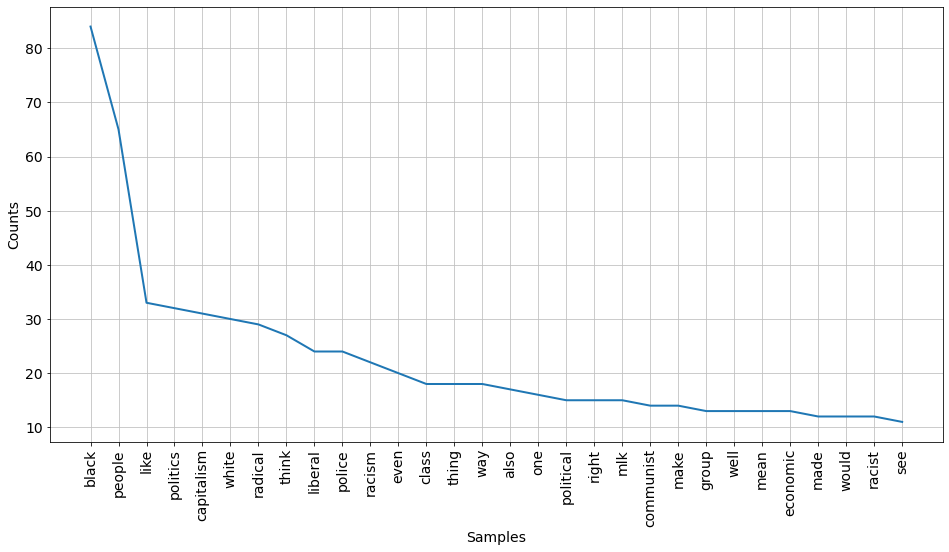

FreqDist({'following': 1,
          'copy': 1,
          'original': 1,
          'post': 4,
          'record': 1,
          'originally': 1,
          'written': 2,
          'new': 2,
          'piece': 2,
          'tnr': 1,
          'stigma': 2,
          'black': 84,
          'political': 15,
          'activism': 5,
          'wanted': 2,
          'see': 11,
          'take': 10,
          'liberal': 24,
          'http': 6,
          'newrepublic': 2,
          'com': 5,
          'article': 7,
          'myth': 2,
          'radical': 29,
          'politics': 32,
          'stymy': 2,
          'progressive': 5,
          'bot': 1,
          'action': 3,
          'performed': 1,
          'automatically': 1,
          'please': 1,
          'contact': 1,
          'moderator': 1,
          'subreddit': 1,
          'message': 4,
          'compose': 1,
          'r': 1,
          'askaliberal': 1,
          'question': 11,
          'concern': 1,
          'think': 27,
  

In [13]:
# frequency of words
word = sentiment_df['Processed_Comment'].apply(pd.Series).stack()
freqdist = FreqDist(word)
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 14})
freqdist.plot(30, cumulative=False)
freqdist

In [14]:
# visualization using wordcloud for the negative sentiment comments
negative_df=sentiment_df[sentiment_df['label']==-1]
word_list = list(chain.from_iterable(negative_df.Processed_Comment.values))
words = ' '.join(word_list)

In [15]:
wordcloud = WordCloud(background_color='black').generate(words)

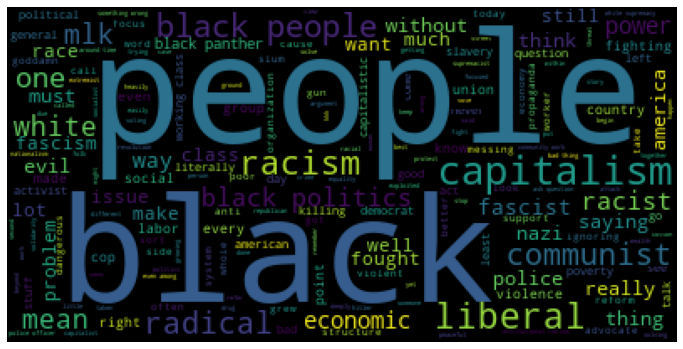

In [16]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
# visualization using wordcloud for the positive sentiment comments
positive_df=sentiment_df[sentiment_df['label']==1]
word_list = list(chain.from_iterable(positive_df.Processed_Comment.values))
words = ' '.join(word_list)


In [18]:
wordcloud = WordCloud(background_color='black').generate(words)

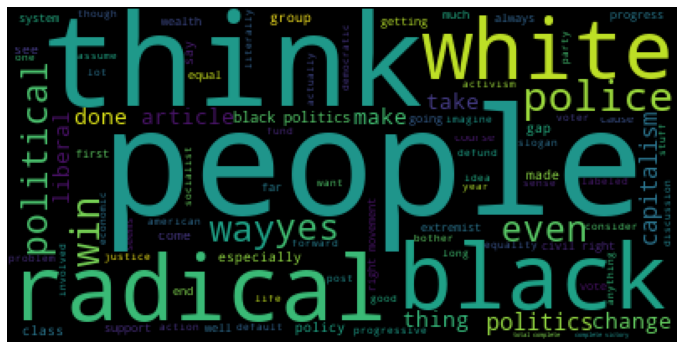

In [19]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
# visualization using wordcloud for the neutral sentiment comments
neutral_df=sentiment_df[sentiment_df['label']==0]
word_list = list(chain.from_iterable(neutral_df.Processed_Comment.values))
words = ' '.join(word_list)

In [21]:
wordcloud = WordCloud(background_color='black').generate(words)

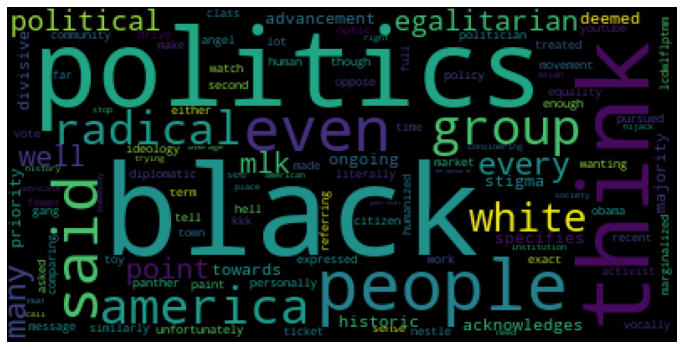

In [22]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()